#  <center> Emotion Recognition from Speech <center>

**Objective:** Recognize human emotions (e.g., happy, angry, sad) from speech audio. 

**Approach:** Apply deep learning and speech signal processing techniques.

**Key Features:**
* Extract features like MFCCs (Mel-Frequency Cepstral Coefficients).
* Use models like CNN, RNN, or LSTM.
* Datasets: RAVDESS, TESS, or EMO-DB.

### I am going to build a speech emotion detection classifier.
### But first we need to learn about what is speech recognition (SER) and why are we building this project? Well, few of the reasons are-

#### First, lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import sys

# Librosa is used for audio analysis
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# For playing audio in notebooks
from IPython.display import Audio

# Deep learning
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical  # ✅ fixed: no np_utils

# Suppress warnings
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

2025-07-19 11:39:09.958903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752925150.201471      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752925150.272648      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Preparation

As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
We will use this dataframe to extract features for our model training.

In [2]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-dataset"
Crema = "/kaggle/input/crema-dataset"
Tess = "/kaggle/input/tess-dataset"
Savee = "/kaggle/input/savee-dataset"

1. Ravdess Dataframe
Here is the filename identifiers as per the official RAVDESS website:

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:

Video-only (02)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12) - Female (as the actor ID number is even)

In [3]:
# ✅ Set the correct path to the dataset (make sure to end WITHOUT a slash)
Ravdess = "/kaggle/input/ravdess-dataset"

# Get list of actor folders
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_folder = os.path.join(Ravdess, dir)
    
    if os.path.isdir(actor_folder):  # Only proceed if it's a directory
        actor_files = os.listdir(actor_folder)
        
        for file in actor_files:
            part = file.split('.')[0].split('-')
            if len(part) >= 3:  # Ensure valid filename format
                try:
                    emotion = int(part[2])
                    file_emotion.append(emotion)
                    file_path.append(os.path.join(actor_folder, file))
                except ValueError:
                    print(f"Skipping invalid filename: {file}")

# Create DataFrames
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Replace emotion numbers with labels
emotion_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}
Ravdess_df['Emotions'].replace(emotion_map, inplace=True)

# Preview the final DataFrame
Ravdess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...
1   neutral  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...
2   disgust  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...
3   disgust  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...
4   neutral  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...

##  <center> 2. Crema DataFrame  <center>

In [4]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                            Path
0  disgust  /kaggle/input/crema-dataset1028_TSI_DIS_XX.wav
1    happy  /kaggle/input/crema-dataset1075_IEO_HAP_LO.wav
2    happy  /kaggle/input/crema-dataset1084_ITS_HAP_XX.wav
3  disgust  /kaggle/input/crema-dataset1067_IWW_DIS_XX.wav
4  disgust  /kaggle/input/crema-dataset1066_TIE_DIS_XX.wav

##  <center> 3. TESS dataset <center>

In [5]:
# ✅ Define the TESS dataset path (adjust as per your environment)
Tess = "/kaggle/input/tess-dataset"

tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    folder_path = os.path.join(Tess, dir)
    
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        for file in files:
            try:
                part = file.split('.')[0].split('_')
                if len(part) >= 3:
                    emotion = part[2].lower()
                    if emotion == 'ps':  # some files have 'ps' instead of 'surprise'
                        emotion = 'surprise'
                    file_emotion.append(emotion)
                    file_path.append(os.path.join(folder_path, file))
            except Exception as e:
                print(f"Skipping file: {file} → Error: {e}")

# Create DataFrame
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

# Show result
Tess_df.head()

Emotions                                               Path
0   surprise  /kaggle/input/tess-dataset/TESS Toronto emotio...
1  surprised  /kaggle/input/tess-dataset/TESS Toronto emotio...

##  <center> 4. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [6]:
# ✅ Define path to the SAVEE dataset folder
Savee = "/kaggle/input/savee-dataset"

savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    full_path = os.path.join(Savee, file)
    
    if file.endswith(".wav"):  # Process only .wav files
        try:
            part = file.split('_')[1]
            ele = part[:-6]
            if ele == 'a':
                emotion = 'angry'
            elif ele == 'd':
                emotion = 'disgust'
            elif ele == 'f':
                emotion = 'fear'
            elif ele == 'h':
                emotion = 'happy'
            elif ele == 'n':
                emotion = 'neutral'
            elif ele == 'sa':
                emotion = 'sad'
            else:
                emotion = 'surprise'

            file_emotion.append(emotion)
            file_path.append(full_path)
        
        except Exception as e:
            print(f"Skipping file: {file} → Error: {e}")

# Create DataFrame
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Empty DataFrame
Columns: [Emotions, Path]
Index: []

In [7]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...
1   neutral  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...
2   disgust  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...
3   disgust  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...
4   neutral  /kaggle/input/ravdess-dataset/Actor_02/03-01-0...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

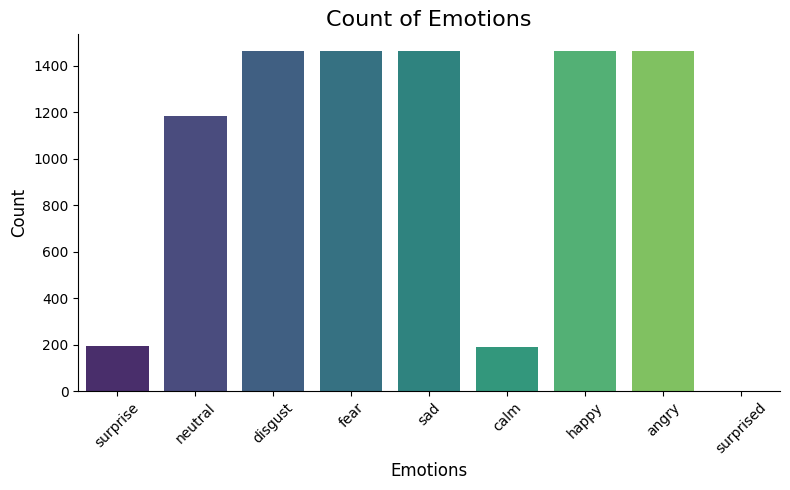

In [8]:
plt.figure(figsize=(8, 5))
plt.title('Count of Emotions', size=16)

# ✅ Fixed line — use keyword argument x=
sns.countplot(x='Emotions', data=data_path, palette='viridis')

plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [10]:
# Helper function: Waveplot
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(data, sr=sr)
    plt.title(f'Waveplot for emotion: {emotion}', fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# Helper function: Spectrogram
def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(f'Spectrogram for emotion: {emotion}', fontsize=14)
    plt.tight_layout()
    plt.show()

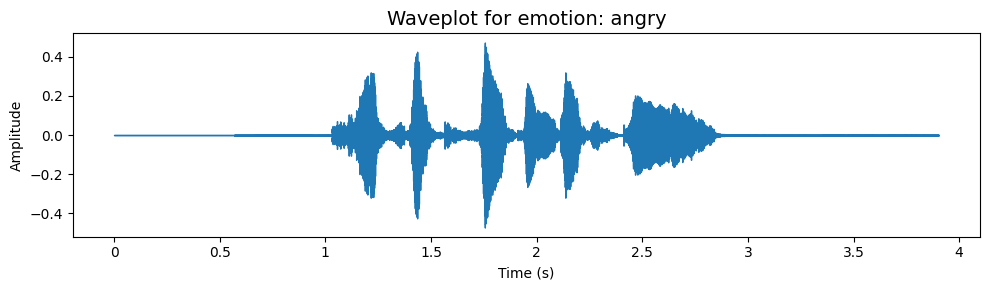

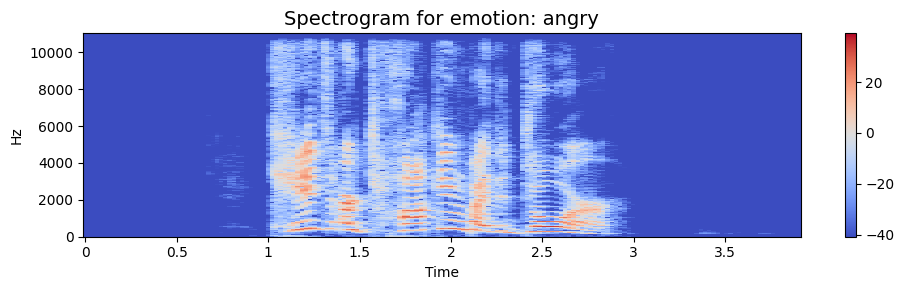

In [11]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

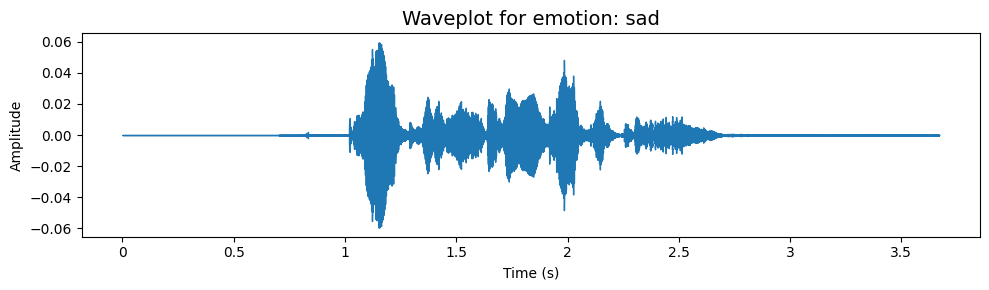

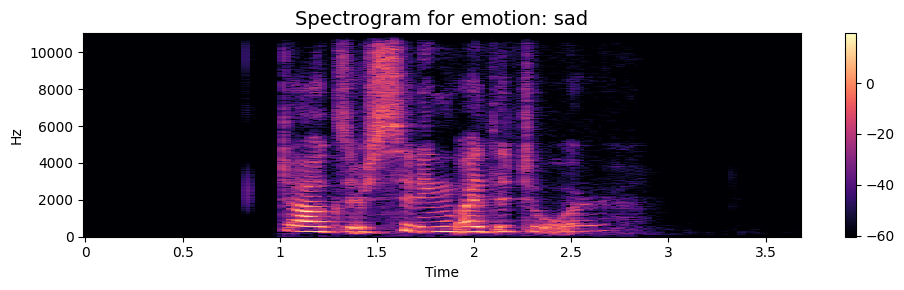

In [12]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

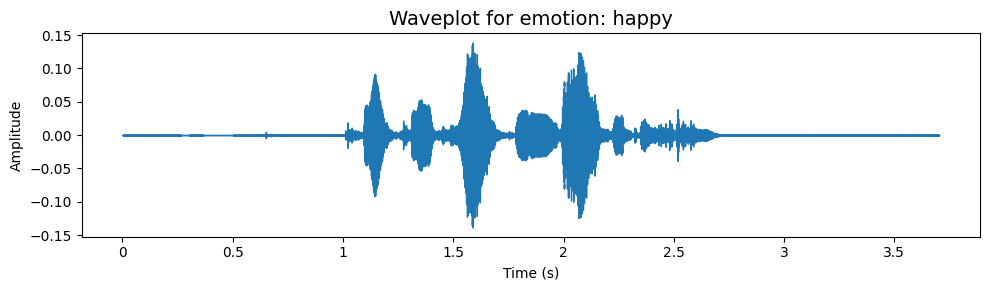

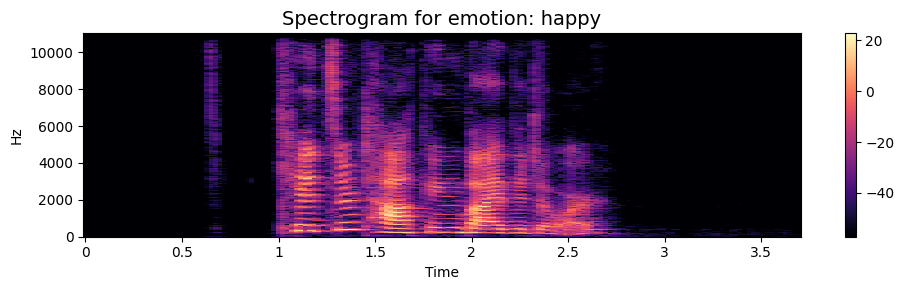

In [13]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [14]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

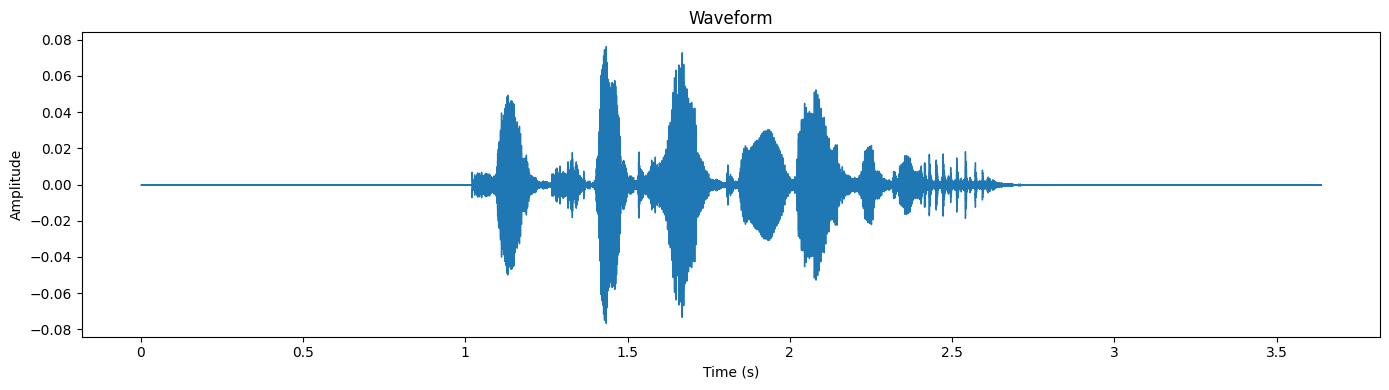

In [15]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sampling_rate)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Audio playback (make sure this is the last line of the cell to display)
Audio(path)

#### 2. Noise Injection

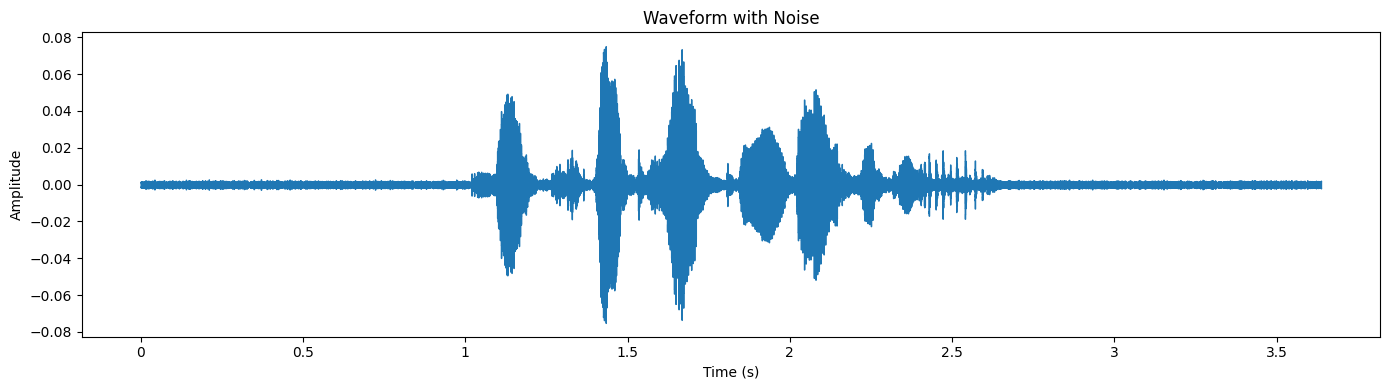

In [16]:
# Assuming `noise()` is a function you've defined to add noise to the audio
x = noise(data)

# Plot the noisy waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title("Waveform with Noise")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Play the noisy audio
Audio(x, rate=sampling_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

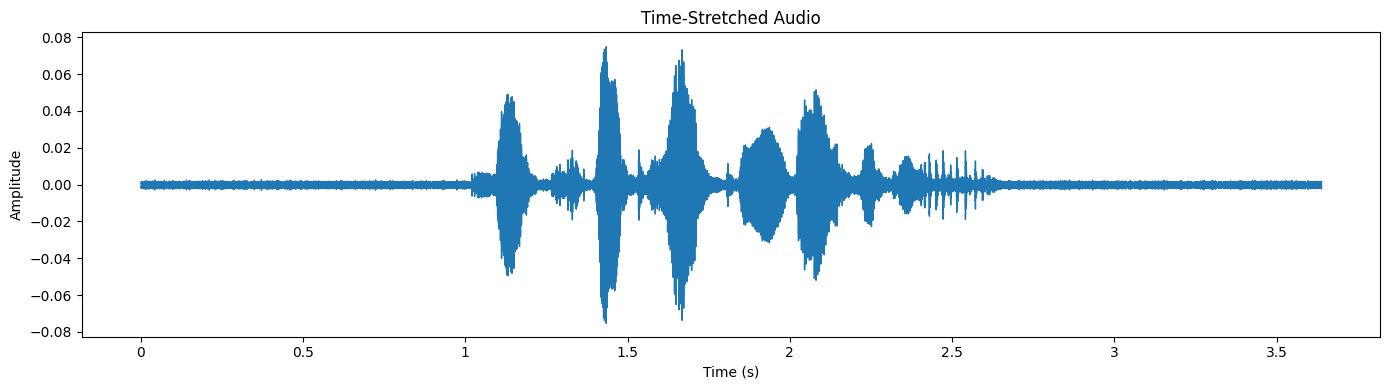

In [17]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title("Time-Stretched Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

Audio(x, rate=sampling_rate)

#### 4. Shifting

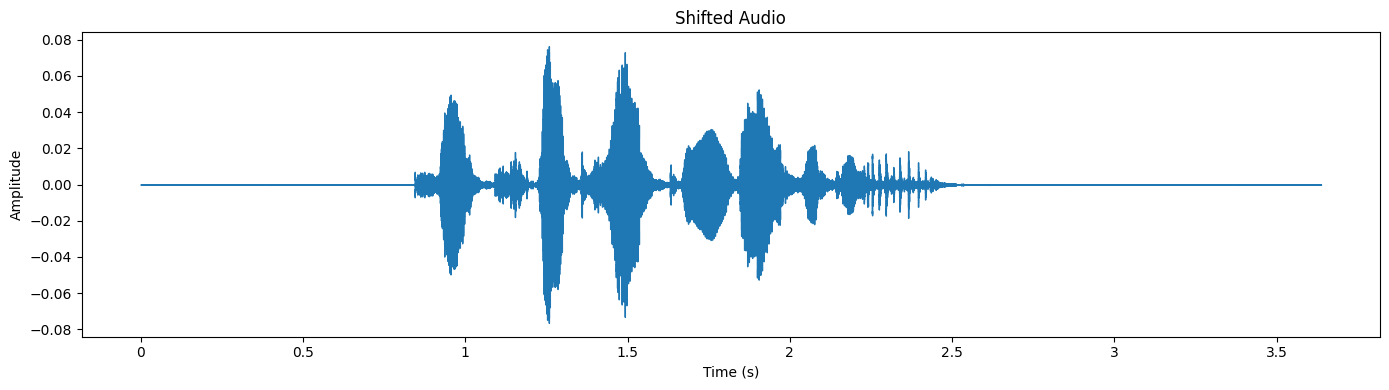

In [18]:
x = shift(data)

# ✅ Plot
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title("Shifted Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# ✅ Play audio
Audio(x, rate=sampling_rate)

#### 5. Pitch

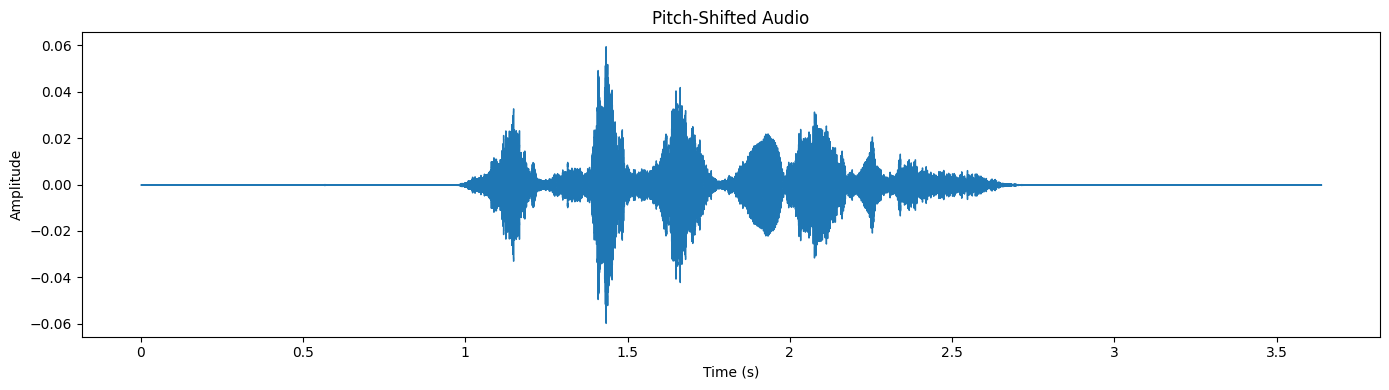

In [19]:
def pitch(data, sr, n_steps=4):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# Apply pitch shifting
x = pitch(data, sampling_rate)  # Make sure your variable is `sampling_rate`

# Plot the pitch-shifted waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
plt.title("Pitch-Shifted Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Play the pitch-shifted audio
Audio(x, rate=sampling_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [20]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    data, sr = librosa.load(path, duration=2.5, offset=0.6)
    
    # Original
    res1 = extract_mfcc(data, sr)

    # With noise
    noise_data = noise(data)
    res2 = extract_mfcc(noise_data, sr)

    # With pitch
    pitch_data = pitch(data, sr)
    res3 = extract_mfcc(pitch_data, sr)

    return [res1, res2, res3]

In [21]:
def extract_mfcc(data, sr, n_mfcc=40):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

In [22]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    try:
        features = get_features(path)
        for feature in features:
            X.append(feature)
            Y.append(emotion)
    except Exception as e:
        print(f"Failed to extract features from {path} due to {e}")

Failed to extract features from /kaggle/input/crema-dataset1028_TSI_DIS_XX.wav due to [Errno 2] No such file or directory: '/kaggle/input/crema-dataset1028_TSI_DIS_XX.wav'
Failed to extract features from /kaggle/input/crema-dataset1075_IEO_HAP_LO.wav due to [Errno 2] No such file or directory: '/kaggle/input/crema-dataset1075_IEO_HAP_LO.wav'
Failed to extract features from /kaggle/input/crema-dataset1084_ITS_HAP_XX.wav due to [Errno 2] No such file or directory: '/kaggle/input/crema-dataset1084_ITS_HAP_XX.wav'
Failed to extract features from /kaggle/input/crema-dataset1067_IWW_DIS_XX.wav due to [Errno 2] No such file or directory: '/kaggle/input/crema-dataset1067_IWW_DIS_XX.wav'
Failed to extract features from /kaggle/input/crema-dataset1066_TIE_DIS_XX.wav due to [Errno 2] No such file or directory: '/kaggle/input/crema-dataset1066_TIE_DIS_XX.wav'
Failed to extract features from /kaggle/input/crema-dataset1027_DFA_DIS_XX.wav due to [Errno 2] No such file or directory: '/kaggle/input/cr

In [23]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (8884,))

In [24]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0          1          2          3          4          5  \
0 -498.171997  53.171150 -22.092064  11.496429 -10.811962 -12.038263   
1 -393.822991  32.457576 -11.187733   1.908328  -9.325989  -9.520546   
2 -516.122498  39.999897 -25.320915   7.333318 -24.138420  -6.861652   
3 -573.702881  74.766006 -16.835480   9.510839  -8.442753  -7.398401   
4 -376.407768  23.280865  -0.974516  -1.358375  -3.871968  -5.026771   

           6          7         8         9  ...        31        32  \
0  -5.335874  -8.586674 -4.736595 -5.701678  ...  5.517719  0.057941   
1  -4.929432  -6.482526 -6.638229 -5.620412  ...  1.908970  0.009604   
2 -10.909740  -7.278124 -8.955425 -6.767918  ...  1.922993 -3.117025   
3  -9.191018 -13.571815 -6.444540 -1.531598  ...  4.441108  2.811377   
4  -6.314146  -7.163734 -4.938823 -2.259070  ...  2.390079  3.553796   

         33        34        35        36        37        38        39  \
0  3.322681  2.238612  5.655242  0.292540  2.936671  1.227493  1.954874   
1  0.859397  1.167007  3.244745  0.952994  1.205592  0.781531  0.347676   
2  0.232830 -0.445753  0.388417 -4.167943  0.248416 -3.554923 -0.617786   
3  6.189663  3.232297  3.908473 -2.468603  1.892174 -1.434031  1.136907   
4  4.614199  3.958490  1.637563  0.242946  0.407460  0.865563  0.773485   

     labels  
0  surprise  
1  surprise  
2  surprise  
3   neutral  
4   neutral  

[5 rows x 41 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [25]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [26]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [27]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 40), (3240, 8), (1080, 40), (1080, 8))

In [28]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 40), (3240, 8), (1080, 40), (1080, 8))

In [29]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 40, 1), (3240, 8), (1080, 40, 1), (1080, 8))

## Modelling

In [30]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

2025-07-19 11:42:02.677057: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 5, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,904 (2.06 MB)

 Trainable params: 540,904 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1591 - loss: 2.0676 - val_accuracy: 0.1963 - val_loss: 2.0275 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1974 - loss: 2.0221 - val_accuracy: 0.2398 - val_loss: 1.9457 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2129 - loss: 1.9709 - val_accuracy: 0.2546 - val_loss: 1.9450 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.2426 - loss: 1.9454 - val_accuracy: 0.2833 - val_loss: 1.8565 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2806 - loss: 1.8730 - val_accuracy: 0.2806 - val_loss: 1.8295 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2673 - loss: 1.8538 - val_accuracy: 0.3028 - val_loss: 1.8008 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3055 - loss: 1.7905 - val_acc

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6263 - loss: 1.5193
Accuracy of our model on test data :  62.40741014480591 %


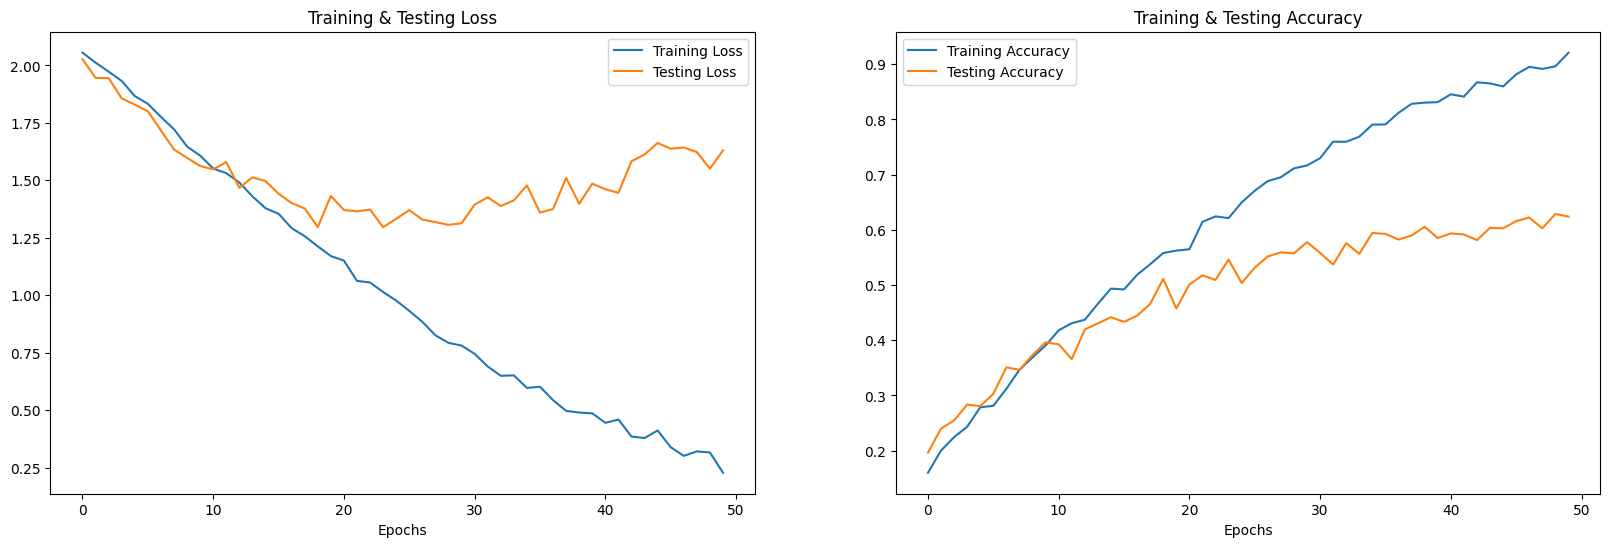

In [32]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [33]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [34]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             fear          fear
1          neutral       neutral
2          disgust           sad
3              sad       neutral
4            happy          fear
5          disgust         angry
6             fear          fear
7              sad          fear
8         surprise       disgust
9          neutral          calm

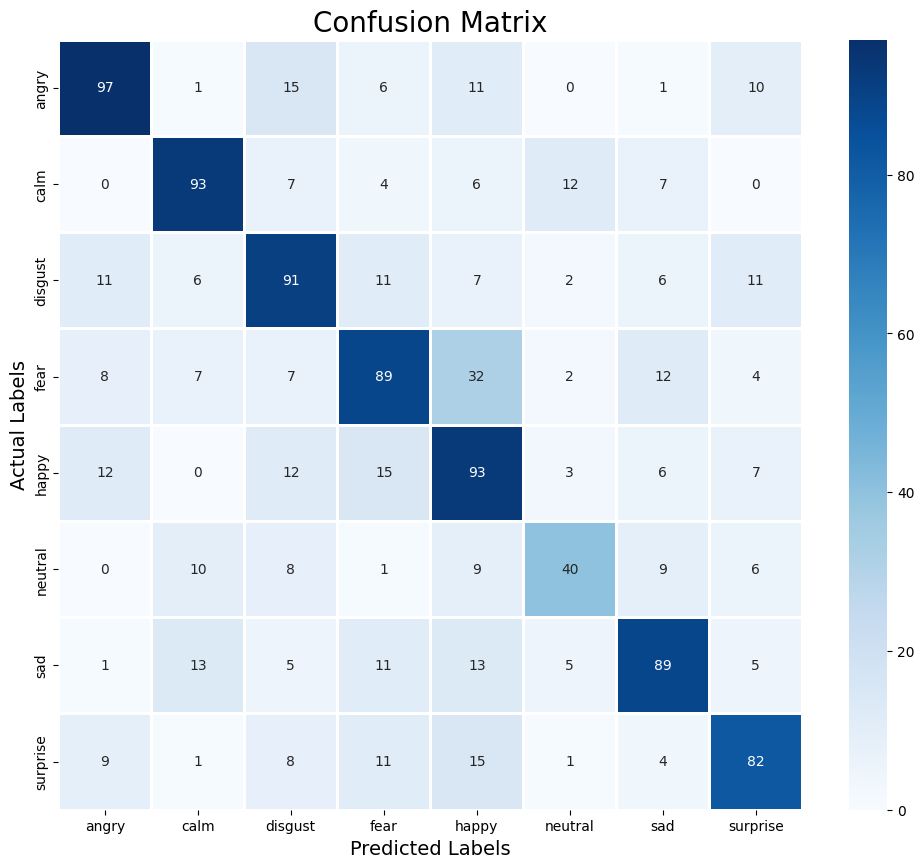

In [35]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.70      0.69      0.70       141
        calm       0.71      0.72      0.72       129
     disgust       0.59      0.63      0.61       145
        fear       0.60      0.55      0.58       161
       happy       0.50      0.63      0.56       148
     neutral       0.62      0.48      0.54        83
         sad       0.66      0.63      0.64       142
    surprise       0.66      0.63      0.64       131

    accuracy                           0.62      1080
   macro avg       0.63      0.62      0.62      1080
weighted avg       0.63      0.62      0.62      1080

